In [172]:
from importlib import reload
import torch
from torch import nn
import pytorch_lightning as pl

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

seed_everything(42)

Global seed set to 42


42

## Dataset

In [149]:
import src.tokenizer
reload(src.tokenizer)
from src.tokenizer import Tokenizer

tokenizer = Tokenizer(alphabet=list(" 'abcdefghijklmnopqrstuvwxyz"))

In [161]:
import torchaudio
from torchaudio.transforms import MFCC
from torch.utils.data import DataLoader, random_split

mfcc = MFCC(sample_rate=16000, n_mfcc=40, melkwargs={'n_mels':64})
def fn(batch):
    X, _, Y, _, _, _  = list(zip(*batch))
    X = [mfcc(x[0]).T for x in X]
    Y = [torch.tensor(tokenizer.encode(y.lower())) for y in Y]
    x_len = torch.tensor([x.shape[0] for x in X])
    Mx = max(x_len)
    y_len = torch.tensor([len(y) for y in Y])
    My = max(y_len)
    return {
        'x' : nn.utils.rnn.pad_sequence(X, batch_first=True).transpose(1,2),
        'x_len' : x_len,
        'y' : nn.utils.rnn.pad_sequence(Y, batch_first=True),
        'y_len': y_len
    }

dataset = torchaudio.datasets.LIBRISPEECH(root='data/', url='dev-clean', download=True)
n = len(dataset)
t = n // 10
train_data, val_data = random_split(dataset, [n -t, t])
tl = DataLoader(train_data, collate_fn=fn, batch_size=8)
vl = DataLoader(val_data, collate_fn=fn, batch_size=8)

In [162]:
b = next(iter(tl))
for k,v in b.items():
    print(k, v.shape)

x torch.Size([8, 40, 1694])
x_len torch.Size([8])
y torch.Size([8, 325])
y_len torch.Size([8])


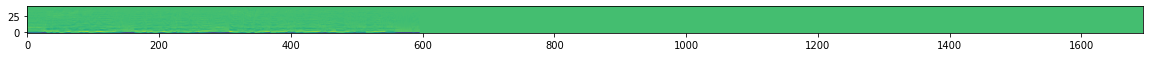

In [163]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.imshow(b['x'][3], origin='lower')

## Model

In [174]:
import src.modules
reload(src.modules)
from src.modules import FactorizedConv, ResBlock, StreamBlock

import src.model
reload(src.model)
from src.model import ASRModel

config = {
    'in_channel' : 40,
    'd_model' : 128,
    'n_vocab' : tokenizer.vocab_size,
    'dropout' : 0.1
}

model = ASRModel(config, tokenizer)
model.count_parameters()

951581

In [171]:
model

ASRModel(
  (criterion): CTCLoss()
  (streams): ModuleList(
    (0): StreamBlock(
      (conv_blocks): ModuleList(
        (0): ResBlock(
          (conv): FactorizedConv(
            (f1): Conv1d(40, 128, kernel_size=(2,), stride=(1,), padding=(1,))
            (f2): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
          )
          (post): Sequential(
            (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): Dropout(p=0.1, inplace=False)
          )
          (scale): Conv1d(40, 128, kernel_size=(1,), stride=(1,))
          (pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
        )
        (1): ResBlock(
          (conv): FactorizedConv(
            (f1): Conv1d(128, 128, kernel_size=(2,), stride=(1,), padding=(1,))
            (f2): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
          )
          (post): Sequential(
            (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=

## train

In [175]:
name = 'test'
logger = TensorBoardLogger(save_dir='logs/', name=name)
checkpoint = ModelCheckpoint(
    dirpath=f'weights/{name}', 
    filename='{epoch}--{val_loss:.2f}', 
    monitor='val_loss',
    mode='min',
    save_top_k=5, 
    every_n_epochs = 1
)

trainer = Trainer(
    benchmark=True, 
    gpus=0, 
    accumulate_grad_batches=1,
    logger=logger, 
    max_epochs=1,
    callbacks=[checkpoint]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [176]:
trainer.fit(model, tl, vl)

Missing logger folder: logs/test

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | CTCLoss    | 0     
1 | streams   | ModuleList | 940 K 
2 | dense     | Linear     | 11.2 K
-----------------------------------------
951 K     Trainable params
0         Non-trainable params
951 K     Total params
3.806     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/soroush/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42
/home/soroush/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

AssertionError: 

In [177]:
trainer.save_checkpoint(f'weights/{name}/last.ckpt')

## predict

In [182]:
# import librosa

# x, _ = librosa.load('test.wav', sr=16000)
# x = librosa.features.mfcc(y=x, n_mfcc=40)
# x = torch.tensor(x)
x = val_data[0][0]
x = mfcc(x[0])
print(model.transcribe(x))

h
